In [2]:
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d vipoooool/new-plant-diseases-dataset
# !unzip new-plant-diseases-dataset.zip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow.keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [4]:
train_datagen = ImageDataGenerator(zoom_range= 0.5,
                                   shear_range= 0.3,
                                   horizontal_flip= True,
                                   preprocessing_function = preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [5]:
train = train_datagen.flow_from_directory(directory ="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                          target_size= (256,256),
                                          batch_size= 32)
val = val_datagen.flow_from_directory(directory ="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                          target_size= (256,256),
                                          batch_size= 32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [6]:
t_img, label = train.next()

In [7]:
def plotImage(img_arr, label):
  for im, l in zip(img_arr, label):
    plt.figure(figsize=(5,5)) 
    plt.show()

In [8]:
plotImage(t_img[:3], label[:3])

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [9]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow import keras

In [10]:
base_model = VGG19(input_shape=(256,256,3), include_top= False)

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
for layer in base_model.layers:
  layer.trainable= False

In [12]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
X = Flatten()(base_model.output)

X = Dense(units = 38, activation='softmax')(X)

#Creating our model
model = Model(base_model.input, X)

In [14]:
model.compile(optimizer= 'adam',
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
#early stopping
es = EarlyStopping(monitor= 'val_accuracy',
                   min_delta = 0.01,
                   patience= 3,
                   verbose= 1)

# model check point
mc = ModelCheckpoint(filepath= "best_model.h5",
                     monitor= 'val_accuracy',
                     min_delta= 0.01,
                     patience= 3, verbose= 1,
                     save_best_only= True)

cb = [es, mc]

In [24]:
his = model.fit_generator(train, 
                steps_per_epoch= 16, 
                epochs= 50,
                verbose= 1,
                callbacks= cb,
                validation_data= val,
                validation_steps= 16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 8.5549 - accuracy: 0.6387
Epoch 1: val_accuracy did not improve from 0.78125
16/16 [==============================] - 13s 802ms/step - loss: 8.5549 - accuracy: 0.6387 - val_loss: 7.9448 - val_accuracy: 0.7246
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 9.7783 - accuracy: 0.6621 
Epoch 2: val_accuracy did not improve from 0.78125
16/16 [==============================] - 13s 786ms/step - loss: 9.7783 - accuracy: 0.6621 - val_loss: 6.9941 - val_accuracy: 0.7617
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 7.4581 - accuracy: 0.7188
Epoch 3: val_accuracy did not improve from 0.78125
16/16 [==============================] - 13s 793ms/step - loss: 7.4581 - accuracy: 0.7188 - val_loss: 5.8590 - val_accuracy: 0.7637
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 9.5947 - accuracy: 0.6855
Epoch 4: val_accuracy did not improve from 0.78125
16/16 [================

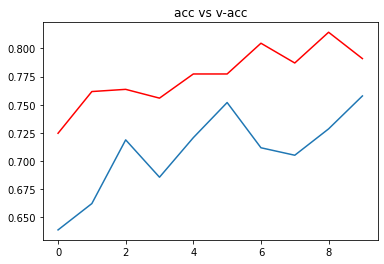

In [25]:
h = his.history
h.keys()

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("acc vs v-acc")
plt.show()

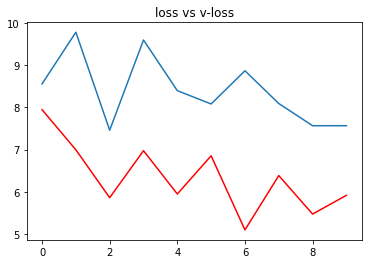

In [26]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("loss vs v-loss")
plt.show()

In [27]:
#load best model

from keras.models import load_model

model = load_model("/content/best_model.h5")

In [28]:
acc = model.evaluate_generator(val)[1] 

print(f"The accuracy of model is : {acc*100}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


The accuracy of model is : 81.95993900299072%


In [29]:
ref = dict(zip(list(train.class_indices.values()),
               list(train.class_indices.keys())))

def prediction(path):

  img = load_img(path, target_size=(256,256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis= 0)
  pred = np.argmax(model.predict(img))
  print(f"the image belongs to {ref[pred]}")

1/1 [==============================] - 0s 155ms/step
the image belongs to Potato___Early_blight


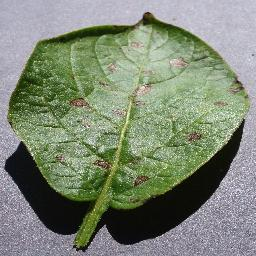

In [30]:
path = "/content/test/test/PotatoEarlyBlight5.JPG"
from IPython.display import Image
prediction(path)
Image(path)